# Generates a mock cluster's AGN and runs emcee to recover the model parameters

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack
from astropy.cosmology import FlatLambdaCDM
from scipy import stats
import astropy.units as u
from time import time
import corner
import emcee
from matplotlib.ticker import MaxNLocator

%matplotlib inline

In [2]:
# Set our cosmology
cosmo = FlatLambdaCDM(H0=70., Om0=0.3)

# Set our random seed
np.random.seed(123)

## Functions needed for mock data generation

In [3]:
def model_rate(z, m, r500, r, params):
    """
    Our generating model.

    :param z: Redshift of the cluster
    :param m: M_500 mass of the cluster
    :param r500: r500 radius of the cluster
    :param r: A vector of radii of objects within the cluster
    :param params: Tuple of (theta, eta, zeta, beta, background)
    :return model: A surface density profile of objects as a function of radius
    """

    # Unpack our parameters
    theta, eta, zeta, beta = params

    theta = theta / u.Mpc**2 * cosmo.kpc_proper_per_arcmin(z).to(u.Mpc/u.arcmin)**2
    background = 0.371 / u.arcmin**2
    r = r * u.arcmin * cosmo.kpc_proper_per_arcmin(z).to(u.Mpc/u.arcmin)

    # The cluster's core radius
    rc = 0.1 * u.Mpc

    # Our amplitude is determined from the cluster data
    a = theta * (1 + z)**eta * (m / (1e15 * u.Msun))**zeta

    # Our model rate is a surface density of objects in angular units (as we only have the background in angular units)
    model = a * (1 + (r / rc) ** 2) ** (-1.5 * beta + 0.5) + background

    # We impose a cut off of all objects with a radius greater than 1.5r500
    model[r / r500 > 1.5] = 0.

    return model.value


def poisson_point_process(model, dx, dy=None):
    """
    Uses a spatial Poisson point process to generate AGN candidate coordinates.

    :param model: The model rate used in the Poisson distribution to determine the number of points being placed.
    :param dx: Upper bound on x-axis (lower bound is set to 0).
    :param dy: Upper bound on y-axis (lower bound is set to 0).
    :return coord: 2d numpy array of (x,y) coordinates of AGN candidates.
    """

    if dy is None:
        dy = dx

    # Draw from Poisson distribution to determine how many points we will place.
    p = stats.poisson(model * dx * dy).rvs()
    print('Number of points placed: ', p)

    # Drop `p` points with uniform x and y coordinates
    x = stats.uniform.rvs(0, dx, size=p)
    y = stats.uniform.rvs(0, dy, size=p)

    # Combine the x and y coordinates.
    coord = np.vstack((x, y))

    return coord


## Functions needed for MCMC fit

In [4]:
# Set our log-likelihood
def lnlike(param, catalog):

    catalog_grp = catalog.group_by('SPT_ID')

    lnlike_list = []
    for cluster in catalog_grp.groups:
        ni = model_rate(cluster['REDSHIFT'][0], cluster['M500'][0]*u.Msun, cluster['r500'][0]*u.Mpc, cluster['radial_arcmin'], param)

        rall = np.linspace(0, 2.5, 100)
        nall = model_rate(cluster['REDSHIFT'][0], cluster['M500'][0]*u.Msun, cluster['r500'][0]*u.Mpc, rall, param)

        # Use a spatial possion point-process log-likelihood
        cluster_lnlike = np.sum(np.log(ni * cluster['radial_arcmin'])) - np.trapz(nall * 2*np.pi * rall, rall)
        lnlike_list.append(cluster_lnlike)

    total_lnlike = np.sum(lnlike_list)

    return total_lnlike


# For our prior, we will choose uninformative priors for all our parameters and for the constant field value we will use
# a gaussian distribution set by the values obtained from the SDWFS data set.
def lnprior(param):
    # Extract our parameters
    theta, eta, zeta, beta = param

    # # Set our hyperparameters
    # h_C = 0.371
    # h_C_err = 0.157

    # Define all priors to be gaussian
    if 0. <= theta <= 100. and -3. <= eta <= 3. and -3. <= zeta <= 3. and -3. <= beta <= 3.:
        theta_lnprior = 0.0
        eta_lnprior = 0.0
        beta_lnprior = 0.0
        zeta_lnprior = 0.0
    else:
        theta_lnprior = -np.inf
        eta_lnprior = -np.inf
        beta_lnprior = -np.inf
        zeta_lnprior = -np.inf

    # C_lnprior = -0.5 * np.sum((C - h_C)**2 / h_C_err**2)

    # Assuming all parameters are independent the joint log-prior is
    total_lnprior = theta_lnprior + eta_lnprior + zeta_lnprior + beta_lnprior #+ C_lnprior

    return total_lnprior


# Define the log-posterior probability
def lnpost(param, catalog):
    lp = lnprior(param)

    # Check the finiteness of the prior.
    if not np.isfinite(lp):
        return -np.inf

    return lp + lnlike(param, catalog)

#### Model parameters:

In [5]:
# Number of clusters to generate
n_cl = 100

# Dx is set to 5 to mimic an IRAC image's width in arcmin.
Dx = 5.

# Set parameter values
theta_true = 5.0     # Amplitude.
eta_true = 1.2       # Redshift slope
beta_true = 0.5      # Radial slope
zeta_true = -1.0     # Mass slope
C_true = 0.371       # Background AGN surface density

params_true = (theta_true, eta_true, zeta_true, beta_true)

## Generate the mock data

In [29]:
# Set up grid of radial positions (normalized by r500)
r_dist = np.linspace(0, 2.5, 100)

# Draw mass and redshift distribution from a uniform distribution as well.
mass_dist = np.random.uniform(0.2e15, 1.8e15, n_cl)
z_dist = np.random.uniform(0.5, 1.7, n_cl)

# Create cluster names
name_bank = ['SPT_Mock_{:03d}'.format(i) for i in range(n_cl)]
SPT_data = Table([name_bank, z_dist, mass_dist], names=['SPT_ID', 'REDSHIFT', 'M500'])

# We'll need the r500 radius for each cluster too.
SPT_data['r500'] = (3 * SPT_data['M500'] /
                    (4 * np.pi * 500 * cosmo.critical_density(SPT_data['REDSHIFT']).to(u.Msun / u.Mpc**3)))**(1/3)
SPT_data_z1 = SPT_data[np.where(SPT_data['REDSHIFT'] >= 1.)]
SPT_data_m = SPT_data[np.where(SPT_data['M500'] <= 5e14)]

In [30]:
cluster_sample = SPT_data

AGN_cats = []
max_rate_list = []
aper_area = []
for cluster in cluster_sample:
    spt_id = cluster['SPT_ID']
    z_cl = cluster['REDSHIFT']
    m500_cl = cluster['M500'] * u.Msun
    r500_cl = cluster['r500'] * u.Mpc
    # print("---\nCluster Data: z = {z:.2f}, M500 = {m:.2e}, r500 = {r:.2f}".format(z=z_cl, m=m500_cl, r=r500_cl))

    area_15r500 = np.pi * (1.5 * r500_cl * cosmo.arcsec_per_kpc_proper(z_cl).to(u.arcmin / u.Mpc))**2
    # print('Aperture Area: {}'.format(area_15r500))
    aper_area.append(area_15r500.value)

    # Calculate the model values for the AGN candidates in the cluster
    rad_model = model_rate(z_cl, m500_cl, r500_cl, r_dist, params_true)

    # Find the maximum rate. This establishes that the number of AGN in the cluster is tied to the redshift and mass of
    # the cluster.
    max_rate = np.max(rad_model)
    # print('Max rate: {}'.format(max_rate))
    max_rate_list.append(max_rate)

    # Simulate the AGN using the spatial Poisson point process.
    agn_coords = poisson_point_process(max_rate, Dx)

    # Find the radius of each point placed scaled by the cluster's r500 radius
    radii = np.sqrt((agn_coords[0] - Dx / 2.) ** 2 + (agn_coords[1] - Dx / 2.) ** 2)

    # Filter the candidates through the model to establish the radial trend in the data.
    rate_at_rad = model_rate(z_cl, m500_cl, r500_cl, radii, params_true)

    # Our rejection rate is the model rate at the radius scaled by the maximum rate
    prob_reject = rate_at_rad / max_rate

    # Draw a random number for each candidate
    alpha = np.random.uniform(0, 1, len(rate_at_rad))

    x_final = agn_coords[0][np.where(prob_reject >= alpha)]
    y_final = agn_coords[1][np.where(prob_reject >= alpha)]
    # print('Number of points in final selection: {}'.format(len(x_final)))

    # Calculate the radii of the final AGN scaled by the cluster's r500 radius
    r_final_arcmin = (np.sqrt((x_final - Dx / 2.) ** 2 + (y_final - Dx / 2.) ** 2) * u.arcmin)
    r_final = r_final_arcmin * cosmo.kpc_proper_per_arcmin(z_cl).to(u.Mpc / u.arcmin)
    r_final_r500 = r_final / r500_cl

    if r_final.size != 0:
        # Create a table of our output objects
        AGN_list = Table([r_final, r_final_arcmin, r_final_r500], names=['radial_Mpc', 'radial_arcmin', 'radial_r500'])
        AGN_list['SPT_ID'] = spt_id
        AGN_list['M500'] = m500_cl
        AGN_list['REDSHIFT'] = z_cl
        AGN_list['r500'] = r500_cl

        AGN_cat = AGN_list['SPT_ID', 'REDSHIFT', 'M500', 'r500', 'radial_Mpc', 'radial_arcmin', 'radial_r500']
        AGN_cats.append(AGN_cat)

outAGN = vstack(AGN_cats)

print('\n------\nparameters: {param}\nTotal number of clusters: {cl} \t Total number of objects: {agn}'
      .format(param=params_true, cl=len(outAGN.group_by('SPT_ID').groups.keys), agn=len(outAGN)))
print('Mean max rate : {} 1 / arcmin2'.format(np.mean(max_rate_list)))
print('Mean aperture area: {} arcmin2'.format(np.mean(aper_area)))

Number of points placed:  83
Number of points placed:  55
Number of points placed:  65
Number of points placed:  250
Number of points placed:  134
Number of points placed:  331
Number of points placed:  28
Number of points placed:  66
Number of points placed:  105
Number of points placed:  67
Number of points placed:  71
Number of points placed:  254
Number of points placed:  151
Number of points placed:  88
Number of points placed:  56
Number of points placed:  130
Number of points placed:  42
Number of points placed:  78
Number of points placed:  55
Number of points placed:  34
Number of points placed:  111
Number of points placed:  294
Number of points placed:  117
Number of points placed:  260
Number of points placed:  133
Number of points placed: 

 56
Number of points placed:  45
Number of points placed:  77
Number of points placed:  290
Number of points placed:  50
Number of points placed:  111
Number of points placed:  99
Number of points placed:  57
Number of points placed:  74
Number of points placed:  31
Number of points placed:  79
Number of points placed:  75
Number of points placed:  202
Number of points placed:  146
Number of points placed:  106
Number of points placed:  130
Number of points placed:  101
Number of points placed:  80
Number of points placed:  53
Number of points placed:  54
Number of points placed:  82
Number of points placed:  102
Number of points placed:  65
Number of points placed:  57
Number of points placed:  174
Number of points placed:  62
Number of points placed:  59
Number of points placed:  69
Number of points placed: 

 182
Number of points placed:  81
Number of points placed:  84
Number of points placed:  60
Number of points placed:  218
Number of points placed:  245
Number of points placed:  62
Number of points placed:  94
Number of points placed:  254
Number of points placed:  127
Number of points placed:  27
Number of points placed:  69
Number of points placed:  48
Number of points placed:  164
Number of points placed:  78
Number of points placed:  81
Number of points placed:  146
Number of points placed:  107
Number of points placed:  178


Number of points placed:  84
Number of points placed:  103
Number of points placed:  29
Number of points placed:  58
Number of points placed:  34
Number of points placed:  253
Number of points placed:  85
Number of points placed:  45
Number of points placed:  124
Number of points placed:  186
Number of points placed:  103


Number of points placed:  53
Number of points placed:  40
Number of points placed:  100
Number of points placed:  75
Number of points placed:  50
Number of points placed:  133
Number of points placed:  192
Number of points placed:  266
Number of points placed:  94
Number of points placed:  136
Number of points placed:  440
Number of points placed:  81
Number of points placed:  33
Number of points placed:  69
Number of points placed:  130
Number of points placed:  144
Number of points placed:  79

------
parameters: (5.0, 1.2, -1.0, 0.5)
Total number of clusters: 100 	 Total number of objects: 3749
Mean max rate : 4.35323538053258 1 / arcmin2
Mean aperture area: 33.746500715763034 arcmin2


### Plot of model rate

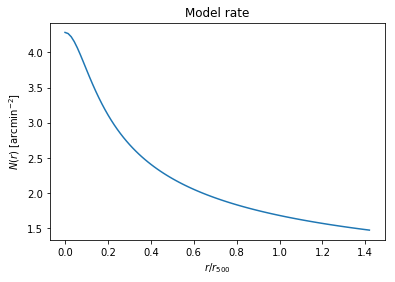

In [31]:
r_r500 = r_dist * u.arcmin * cosmo.kpc_proper_per_arcmin(z_cl).to(u.Mpc/u.arcmin) / r500_cl
fig, ax = plt.subplots()
ax.plot(r_r500, rad_model)
ax.set(title='Model rate', xlabel=r'$r/r_{500}$', ylabel=r'$N(r)$ [arcmin$^{-2}$]')
plt.show()

### Plot of AGN candidates

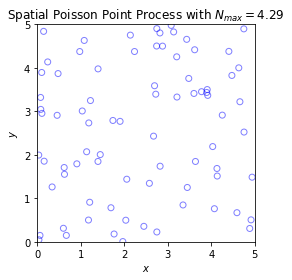

In [32]:
fig, ax = plt.subplots()
ax.scatter(agn_coords[0], agn_coords[1], edgecolor='b', facecolor='none', alpha=0.5)
ax.set_aspect(1.0)
ax.set(title=r'Spatial Poisson Point Process with $N_{{max}} = {:.2f}$'.format(max_rate),
       xlabel=r'$x$', ylabel=r'$y$', xlim=[0, Dx], ylim=[0, Dx])
plt.show()

### Plot of selected AGN

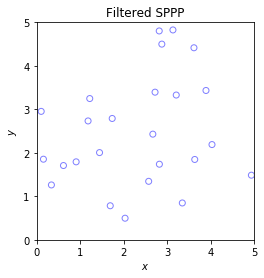

In [33]:
fig, ax = plt.subplots()
ax.scatter(x_final, y_final, edgecolor='b', facecolor='none', alpha=0.5)
ax.set_aspect(1.0)
ax.set(title='Filtered SPPP', xlabel=r'$x$', ylabel=r'$y$', xlim=[0, Dx], ylim=[0, Dx])
plt.show()

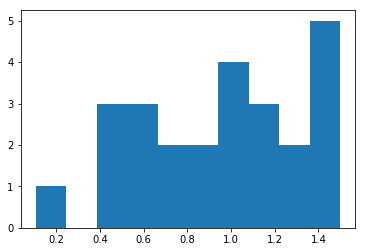

In [53]:
hist, bin_edges = np.histogram(r_final_r500)
bins = (bin_edges[1:len(bin_edges)]-bin_edges[0:len(bin_edges)-1])/2. + bin_edges[0:len(bin_edges)-1]
plt.hist(r_final_r500)

# but normalise the area
area_edges = np.pi * (bin_edges * r500_cl)**2
area = area_edges[1:len(area_edges)]-area_edges[0:len(area_edges)-1]
area_arcmin2 = area * cosmo.arcsec_per_kpc_proper(z_cl).to(u.arcmin / u.Mpc)**2

err = np.sqrt(hist)/area_arcmin2.value

In [56]:
print(rad_model)

[ 4.28506443  4.26938496  4.22415854  4.15423345  4.06608396  3.96631482
  3.86063379  3.7534198   3.64772796  3.54551091  3.44789583  3.35543498
  3.26830187  3.18643307  3.10962539  3.03760002  2.97004376  2.90663446
  2.84705638  2.79100877  2.73821034  2.68840106  2.6413424   2.59681659
  2.55462545  2.51458894  2.47654359  2.44034106  2.4058466   2.37293778
  2.34150322  2.3114415   2.28266009  2.25507453  2.22860754  2.20318834
  2.17875202  2.15523892  2.13259414  2.11076709  2.0897111   2.06938299
  2.04974284  2.03075361  2.01238095  1.99459291  1.97735977  1.96065384
  1.94444927  1.92872194  1.91344927  1.89861014  1.88418474  1.87015448
  1.85650192  1.84321065  1.83026523  1.81765111  1.80535457  1.79336267
  1.78166319  1.77024456  1.75909586  1.74820672  1.73756733  1.72716838
  1.71700103  1.70705691  1.69732803  1.6878068   1.678486    1.66935877
  1.66041854  1.65165907  1.64307439  1.63465881  1.62640688  1.61831342
  1.61037345  1.60258221  1.59493513  1.58742787  1

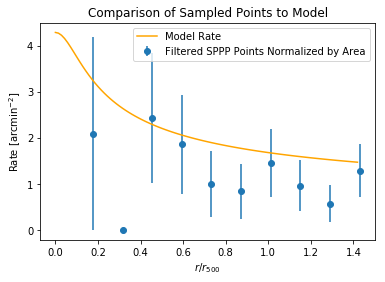

In [55]:
fig, ax = plt.subplots()
ax.errorbar(bins, hist/area_arcmin2.value, yerr=err, fmt='o', label='Filtered SPPP Points Normalized by Area')
ax.plot(r_r500, rad_model, color="orange", label='Model Rate')
ax.set(title='Comparison of Sampled Points to Model', xlabel=r'$r/r_{{500}}$', ylabel=r'Rate [arcmin$^{-2}$]')
ax.legend()
plt.show()

## Fit the data to recover the model parameters using MCMC

In [13]:
# Typically this would be in another script so we'd be reading in the catalog from file.
mock_catalog = outAGN

In [14]:
# Set up our MCMC sampler.
# Set the number of dimensions for the parameter space and the number of walkers to use to explore the space.
ndim = 4
nwalkers = 200

# Also, set the number of steps to run the sampler for.
nsteps = 500

In [15]:
# We will initialize our walkers in a tight ball near the initial parameter values.
pos0 = emcee.utils.sample_ball(p0=[theta_true, eta_true, zeta_true, beta_true],
                               std=[1e-2, 1e-2, 1e-2, 1e-2], size=nwalkers)

# Initialize the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnpost, args=[mock_catalog], threads=1)

In [16]:
# Run the sampler.
start_sampler_time = time()
sampler.run_mcmc(pos0, nsteps)
print('Sampler runtime: {:.2f} s'.format(time() - start_sampler_time))

Sampler runtime: 192.34 s


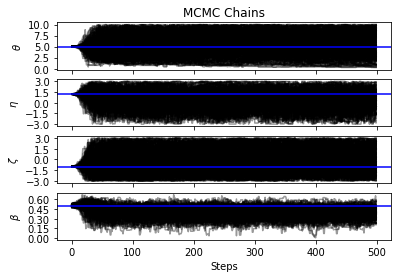

In [17]:
# Plot the chains
fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=4, ncols=1, sharex=True)

ax0.plot(sampler.chain[:, :, 0].T, color='k', alpha=0.4)
ax0.axhline(theta_true, color='b')
ax0.yaxis.set_major_locator(MaxNLocator(5))
ax0.set(ylabel=r'$\theta$', title='MCMC Chains')

ax1.plot(sampler.chain[:, :, 1].T, color='k', alpha=0.4)
ax1.axhline(eta_true, color='b')
ax1.yaxis.set_major_locator(MaxNLocator(5))
ax1.set(ylabel=r'$\eta$')

ax2.plot(sampler.chain[:, :, 2].T, color='k', alpha=0.4)
ax2.axhline(zeta_true, color='b')
ax2.yaxis.set_major_locator(MaxNLocator(5))
ax2.set(ylabel=r'$\zeta$')

ax3.plot(sampler.chain[:, :, 3].T, color='k', alpha=0.4)
ax3.axhline(beta_true, color='b')
ax3.yaxis.set_major_locator(MaxNLocator(5))
ax3.set(ylabel=r'$\beta$', xlabel='Steps')

plt.show()

In [18]:
# Remove the burnin, typically 1/3 number of steps
burnin = nsteps//3
samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))

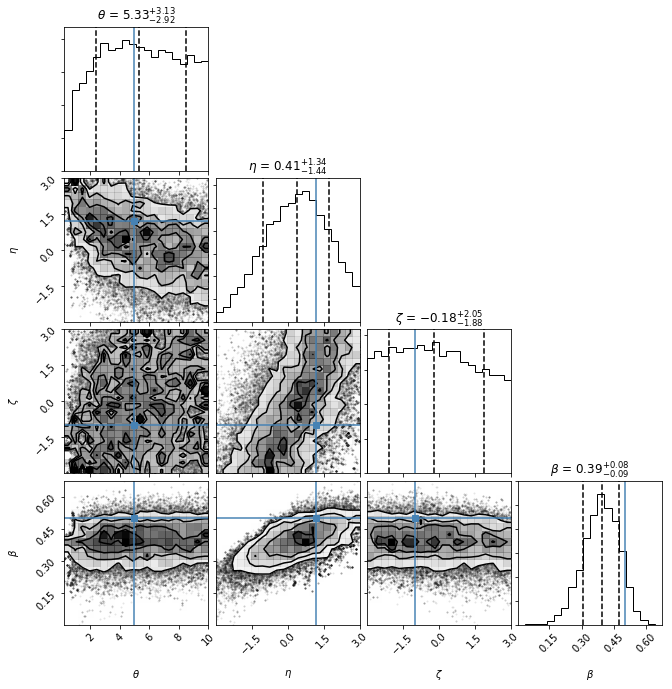

In [19]:
# Produce the corner plot
fig = corner.corner(samples, labels=[r'$\theta$', r'$\eta$', r'$\zeta$', r'$\beta$'],
                    truths=[theta_true, eta_true, zeta_true, beta_true],
                    quantiles=[0.16, 0.5, 0.84], show_titles=True)

In [20]:
theta_mcmc, eta_mcmc, zeta_mcmc, beta_mcmc = map(lambda v: (v[1], v[2] - v[1], v[1] - v[0]),
                                                 zip(*np.percentile(samples, [16, 50, 84], axis=0)))
print("""MCMC Results:
theta = {theta[0]:.2f} +{theta[1]:.3f} -{theta[2]:.3f} (truth: {theta_true})
eta = {eta[0]:.2f} +{eta[1]:.3f} -{eta[2]:.3f} (truth: {eta_true})
zeta = {zeta[0]:.2f} +{zeta[1]:.3f} -{zeta[2]:.3f} (truth: {zeta_true})
beta = {beta[0]:.2f} +{beta[1]:.3f} -{beta[2]:.3f} (truth: {beta_true})"""
      .format(theta=theta_mcmc, eta=eta_mcmc,  zeta=zeta_mcmc, beta=beta_mcmc,
              theta_true=theta_true, eta_true=eta_true,  zeta_true=zeta_true, beta_true=beta_true))

print('Mean acceptance fraction: {}'.format(np.mean(sampler.acceptance_fraction)))

MCMC Results:
theta = 5.33 +3.131 -2.923 (truth: 5.0)
eta = 0.41 +1.336 -1.444 (truth: 1.2)
zeta = -0.18 +2.047 -1.881 (truth: -1.0)
beta = 0.39 +0.081 -0.086 (truth: 0.5)
Mean acceptance fraction: 0.46649
